### Note: This should be the master notebook from here on (Dec 21, 2020). It is relatively quick to run everything and much cleaner than the notebook "OD Visualization". 

In [3]:
#Set up workspace
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
import geopy.distance
import time
import os

In [4]:
MSAs = ['Atlanta','Boston','Chicago','Dallas','DC','Denver','Detroit','Houston','Los Angeles','Miami','Minneapolis',
        'NYC','Phoenix','San Fran','Seattle']

In [5]:
os.chdir('/Users/thomashill/Dropbox/Academic/Dissertation/Empirics/OD_Project/Geocoded Files 5.4')

Read in the necessary data. 

In [6]:
blocks_dfs = []
od_dfs = []

for msa in MSAs:
    block_df = pd.read_csv(str(msa)+'_blocks.csv')
    od_df = pd.read_csv(str(msa)+'_OD.csv')
    
    blocks_dfs.append(block_df)
    od_dfs.append(od_df)
    
blocks_dict = dict(zip(MSAs,blocks_dfs))
od_dict = dict(zip(MSAs,od_dfs))

In [7]:
#Ok, convert land area from meters to miles by dividing by 2.59e+6

new_blocks_dfs = []
new_od_dfs = []

for msa in MSAs:
    df = blocks_dict[msa]
    df['Land Area'] = df['ALAND10']/2.59e+6
    df['Work Density'] = df['Commuters']/df['Land Area']
    df = df.drop(["Unnamed: 0"],axis=1)
    df = df.drop(["ALAND10"],axis=1)
    
    od_df = od_dict[msa]
    od_df = od_df.drop(["Unnamed: 0"],axis=1)
    od_df = od_df.drop(["level_0"],axis=1)
    od_df = od_df.drop(["index"],axis=1)
    
    new_blocks_dfs.append(df)
    new_od_dfs.append(od_df)
    
blocks_dict = dict(zip(MSAs,new_blocks_dfs))
od_dict = dict(zip(MSAs,new_od_dfs))

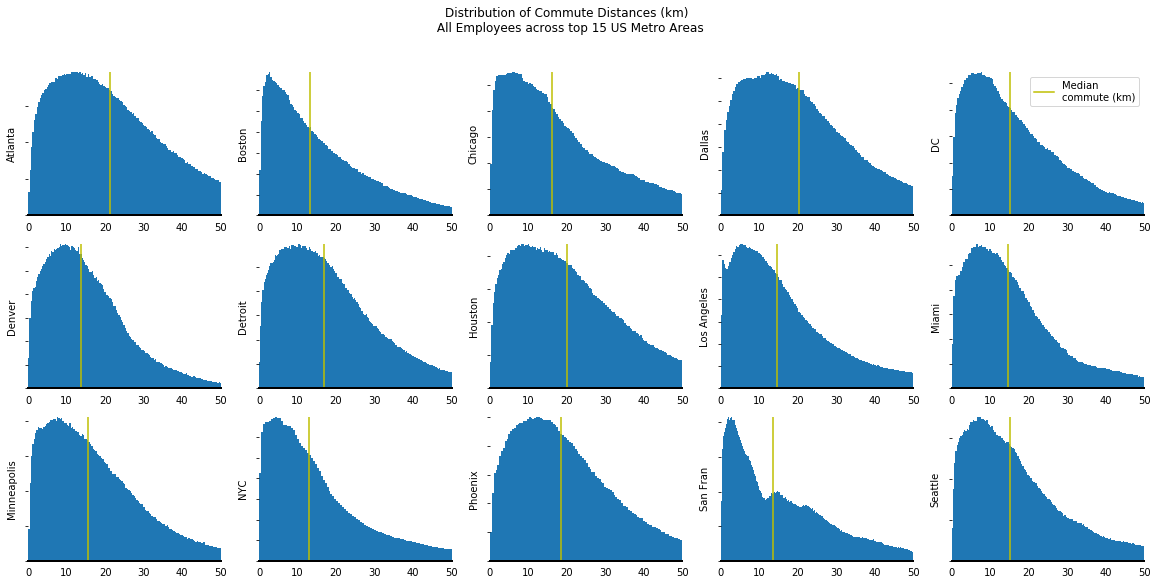

In [8]:
fig,ax = plt.subplots(3,5,figsize=(20,9))

dist_lim = 50

for i in range(3):
    for j in range(5):
        order = i*5 + j
        msa = MSAs[order]

        ax[i,j].hist(od_dict[msa]['Commute Distance'],bins=500)
        ax[i,j].set_yticklabels([])
        for spine in ["left", "right", "top"]:
            ax[i,j].spines[spine].set_visible(False)
            
        #Plot vertical line for median commute
        median = np.median(od_dict[msa]['Commute Distance'])
        
        if i == 0:
            if j == 4:
                ax[i,j].axvline(x=median, ymin=0, ymax=1,color='y',label="Median \ncommute (km)")
                ax[i,j].legend()
            else:
                ax[i,j].axvline(x=median, ymin=0, ymax=1,color='y')
        else:
            ax[i,j].axvline(x=median, ymin=0, ymax=1,color='y')
        
        ax[i,j].spines["bottom"].set_linewidth(2)
        ax[i,j].margins(y=0)
        ax[i,j].tick_params(bottom=False)
        ax[i,j].set_ylabel(msa)
        
        ax[i,j].set_xlim([0,dist_lim])

fig.suptitle('Distribution of Commute Distances (km) \n All Employees across top 15 US Metro Areas')
#fig.subtitle('Distance (kilometers)')
plt.show()

Ok, now let's combine all of the above into a single dataframe.

In [9]:
#First, lets combine all of the above into a single df so we can do some visualization
dfs = []
for msa in MSAs:
    df = od_dict[msa]
    df['City'] = msa
    dfs.append(df)

ods_all = pd.concat(dfs)

In [10]:
median_commutes = []
for msa in MSAs:
    median_commute = np.median(od_dict[msa]['Commute Distance'])
    median_commutes.append(median_commute)

commutes_df = pd.DataFrame({
    'MSA': MSAs,
    'Median Commute': median_commutes})

#Sort the above
commutes_df = commutes_df.sort_values(by='Median Commute',ascending=False)

#And get the order, for plotting
order = list(commutes_df['MSA'])

#Zip it all up
commutes_dict = dict(zip(MSAs,median_commutes))

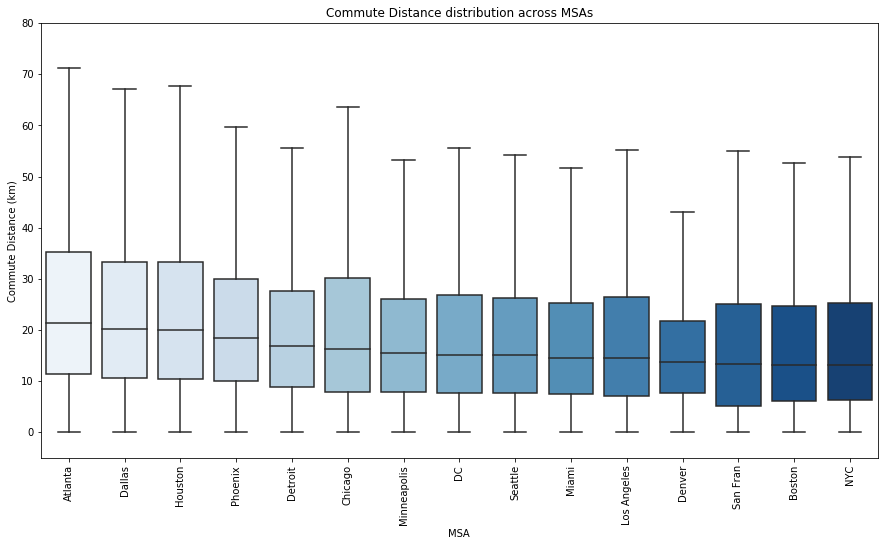

In [11]:
fig, ax = plt.subplots(1, 1, figsize=(15, 8))
ax = sns.boxplot(x="City", y="Commute Distance", data=ods_all,order=order,fliersize = 0, palette = 'Blues')
#ax.set_ylim([-5, 80]) 
ax.set(ylim=[-5, 80],title='Commute Distance distribution across MSAs',xlabel='MSA',ylabel='Commute Distance (km)')
for tick in ax.get_xticklabels():
    tick.set_rotation(90)

Commute distances do not scale in any obvious way with population size: median commute distances are in fact the lowest in New York City (the largest MSA in the sample). Perhaps unsurprisingly, they are largest for those sunbelt cities commonly associated with sprawl: Atlanta, Dallas, Houston and Phoenix. Interestingly, median commute distance in Los Angeles is on the lower side, in spite of that region's reputation for sprawl and crippling commutes. 

### The Clustering of Employment in Metropolitan Regions

Let's try to understand how employment clusters in space, within and across these different metropolitan areas. Maybe this will shed light on how commutes are distributed.

First question: how concentrated is employment in each of these areas? There are a couple ways to measure this...

Let's start by calculating the density of workers (in-commuters) in every block, as well as the proportion of total regional employment represented by each. We'll also sort the dataframe by commuter density, so that when we go down the list of blocks we know we have clustered the maximum number of possible workers within the smallest possible area which any ordering of blocks in the metro area would allow.

In [12]:
new_dfs = []
msa_areas = []
for msa in MSAs:
    df = blocks_dict[msa].sort_values(by='Work Density',ascending=False)
    df_area = np.sum(df['Land Area'])
    df_workforce = np.sum(df['Commuters'])
    block_areas = np.array(df['Land Area'])
    commuters = np.array(df['Commuters'])
    
    msa_areas.append(df_area)
    land_props = block_areas/df_area
    work_props = commuters/df_workforce
    
    df['Block Proportion'] = land_props
    df['Work Proportion'] = work_props
    
    #df = df.drop(["Unnamed: 0"],axis=1)
    
    #And let's get the ranking
    df = df.reset_index()
    df = df.drop(['index'],axis=1)
    df = df.reset_index()

    df['Work Density Rank'] = df['index'] + 1
    df = df.drop(['index'],axis=1)
    
    #df = df.drop(['Cum Block Area'],axis=1)
    #df = df.drop(['Cum Workers'],axis=1)
    
    new_dfs.append(df)
    
blocks_dict = dict(zip(MSAs,new_dfs))
msa_areas_dict = dict(zip(MSAs,msa_areas))

From the above newly created fields, let's get the cumulative share of the workforce represented as we go down the list of blocks.

In [13]:
new_dfs = []

for msa in MSAs:
    df = blocks_dict[msa]
    
    land_cum = list(np.array(df['Block Proportion']).cumsum())
    work_cum = list(np.array(df['Work Proportion']).cumsum())
    
    df['Cumulative Land'] = land_cum
    df['Cumulative Workers'] = work_cum
    
    new_dfs.append(df)
    
blocks_dict = dict(zip(MSAs,new_dfs))              

Now let's plot each of these.

/opt/anaconda3/lib/python3.7/site-packages/IPython/core/pylabtools.py:128: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


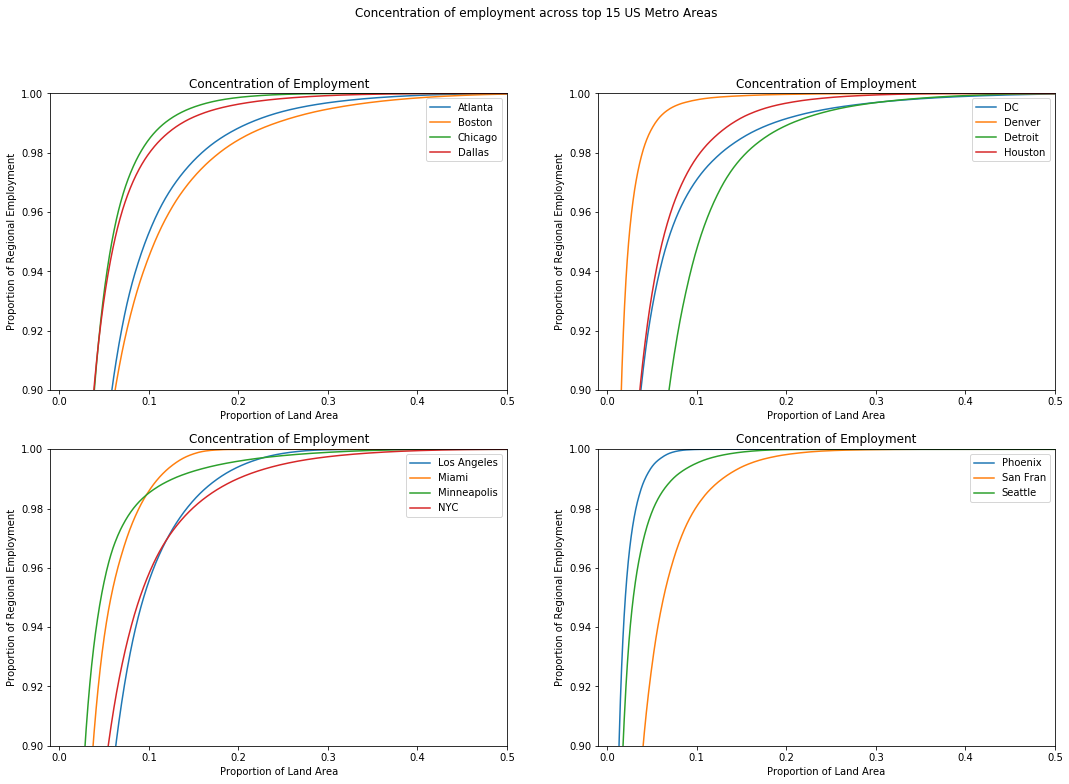

In [14]:
msa_list_1 = ['Atlanta','Boston','Chicago','Dallas']
msa_list_2 = ['DC','Denver','Detroit','Houston']
msa_list_3 = ['Los Angeles','Miami','Minneapolis','NYC']
msa_list_4 = ['Phoenix','San Fran','Seattle']

msa_lists = [msa_list_1,msa_list_2,msa_list_3,msa_list_4]

#plot_concentration(msa_list_1)

fig,ax = plt.subplots(2,2,figsize=(18,12))

a = 0

for i in range(2):
    for j in range(2):
        msa_list = msa_lists[a]
        
        a = a + 1
        
        #fig, ax = plt.subplots(2, 2, figsize=(8, 5))

        for msa in msa_list:
            msa_df = blocks_dict[msa]
            area_props = msa_df['Cumulative Land']
            work_props = msa_df['Cumulative Workers']

            ax[i,j].plot(area_props,work_props,label=msa)

            ax[i,j].set_xlabel('Proportion of Land Area')
            ax[i,j].set_ylabel('Proportion of Regional Employment')
            ax[i,j].set_title('Concentration of Employment')
            ax[i,j].set_xlim([-0.01,0.5])
            ax[i,j].set_ylim([0.9,1.0])
            ax[i,j].legend()
        
fig.suptitle('Concentration of employment across top 15 US Metro Areas')
plt.show()

As the above plot shows, employment is tightly concentrated in all regions: the vast majority of employment is clustered in a tiny proportion of the region's land area. 

Note that this concentration appears higher in more "sprawling" regions: employment is clustered in an extremely tiny proportion of land area in Phoenix, Miami, etc.

Is there a way to measure the degree of concentration? Probably....but note that this might not be so useful, since this measure of "degree of concentration" is largely a function of the spatial expanse of a metropolitan region.

### Read in and assign demographic data to the above.

In [15]:
#Read in demographic data, sourced from Social Explorer
#https://www.socialexplorer.com/tables/C2010/R12522037

os.chdir('/Users/thomashill/Dropbox/Academic/Dissertation/Empirics/OD_Project/Demographics')
pop_data = pd.read_csv("R12522037_SL100.csv")

rel_cols = ['Geo_STATE','Geo_FIPS','SE_T001_001']
pop_data = pop_data[rel_cols]
pop_data = pop_data.rename(columns={'Geo_FIPS':'Block','SE_T001_001':'Population'})

state_codes = pd.read_csv('State Codes.csv')

In [16]:
state_names = []
state_ids = list(set(pop_data['Geo_STATE']))
for state_id in state_ids:
    state = np.array(state_codes.loc[state_codes['Code']==state_id]['Abbrev'])[0]
    state_names.append(state)

state_id_dict = dict(zip(state_ids,state_names))

#Use the above dictionary to assign the state name to each block
pop_data['State'] = pop_data['Geo_STATE'].map(state_id_dict)

In [17]:
#Get all blocks
msa_keys = list(blocks_dict.keys())

all_blocks = []
for msa in msa_keys:
    blocks_df = blocks_dict[msa]
    msa_blocks = np.array(blocks_df['GEOID10'])
    all_blocks.append(msa_blocks)

all_blocks = list(set(np.concatenate(all_blocks, axis=None)))

In [18]:
pop_df = pop_data[pop_data["Block"].isin(all_blocks)]

#And let's get the ranking
pop_df = pop_df.reset_index()
pop_df = pop_df.drop(['index'],axis=1)

block_pop_dict = dict(zip(np.array(pop_data['Block']),np.array(pop_data['Population'])))

msa_keys = list(blocks_dict.keys())
#rel_cols = ['GEOID10','INTPTLAT10','INTPTLON10','Commuters','Land Area']

new_blocks_dfs = []

for msa in msa_keys:
    blocks_df = blocks_dict[msa]
    #blocks_df = blocks_df[rel_cols]
    
    blocks_df['Population'] = blocks_df['GEOID10'].map(block_pop_dict)
    
    new_blocks_dfs.append(blocks_df)
    
blocks_dict = dict(zip(MSAs,new_blocks_dfs))

In [19]:
msa_blocks = []

for msa in MSAs:
    df_blocks = blocks_dict[msa]
    df_blocks['Pop Density'] = df_blocks['Population']/df_blocks['Land Area']
    df_blocks['Work Density'] = df_blocks['Commuters']/df_blocks['Land Area']
    df_blocks['Work-Life Total'] = df_blocks['Population'] + df_blocks['Commuters']
    df_blocks['Work Ratio'] = df_blocks['Commuters']/df_blocks['Work-Life Total']
    df_blocks['Work Ratio'] = df_blocks['Work Ratio'].fillna(0)
    
    df_blocks = df_blocks.sort_values(by='Work Ratio',ascending=False)
    
    msa_blocks.append(df_blocks)
    
blocks_dict = dict(zip(MSAs,msa_blocks))

In [20]:
new_dfs = []
msa_areas = []
for msa in MSAs:
    df = blocks_dict[msa].sort_values(by='Work Density',ascending=False)
    df_area = np.sum(df['Land Area'])
    df_workforce = np.sum(df['Commuters'])
    df_population = np.sum(df['Population'])
    
    block_areas = np.array(df['Land Area'])
    commuters = np.array(df['Commuters'])
    
    msa_areas.append(df_area)
    
    land_props = block_areas/df_area
    work_props = commuters/df_workforce
    
    #####POPULATION
    population = np.array(df['Population'])
    pop_props = population/df_population
    
    df['Block Proportion'] = land_props
    df['Work Proportion'] = work_props
    
    df['Population Proportion'] = pop_props
    
    #And let's get the ranking by worker density
    df = df.reset_index()
    df = df.drop(['index'],axis=1)
    df = df.reset_index()

    df['Work Density Rank'] = df['index'] + 1
    df = df.drop(['index'],axis=1)
    
    #...and now the ranking by population density
    df = df.sort_values(by='Pop Density',ascending=False)
    df = df.reset_index()
    df = df.drop(['index'],axis=1)
    df = df.reset_index()
    
    df['Pop Density Rank'] = df['index'] + 1
    df = df.drop(['index'],axis=1)
    
    new_dfs.append(df)
    
blocks_dict = dict(zip(MSAs,new_dfs))
msa_areas_dict = dict(zip(MSAs,msa_areas))

In [21]:
new_dfs = []

for msa in MSAs:
    df = blocks_dict[msa].sort_values(by='Work Density',ascending=False)
    
    land_cum = list(np.array(df['Block Proportion']).cumsum())
    work_cum = list(np.array(df['Work Proportion']).cumsum())
    
    df['Cumulative Land - Work'] = land_cum
    df['Cumulative Workers'] = work_cum
    
    df = df.sort_values(by='Pop Density',ascending=False)
    
    land_cum = list(np.array(df['Block Proportion']).cumsum())
    pop_cum = list(np.array(df['Population Proportion']).cumsum())
    
    df['Cumulative Land - Pop'] = land_cum
    df['Cumulative Residents'] = pop_cum
    
    new_dfs.append(df)
    
blocks_dict = dict(zip(MSAs,new_dfs))              

/opt/anaconda3/lib/python3.7/site-packages/IPython/core/pylabtools.py:128: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


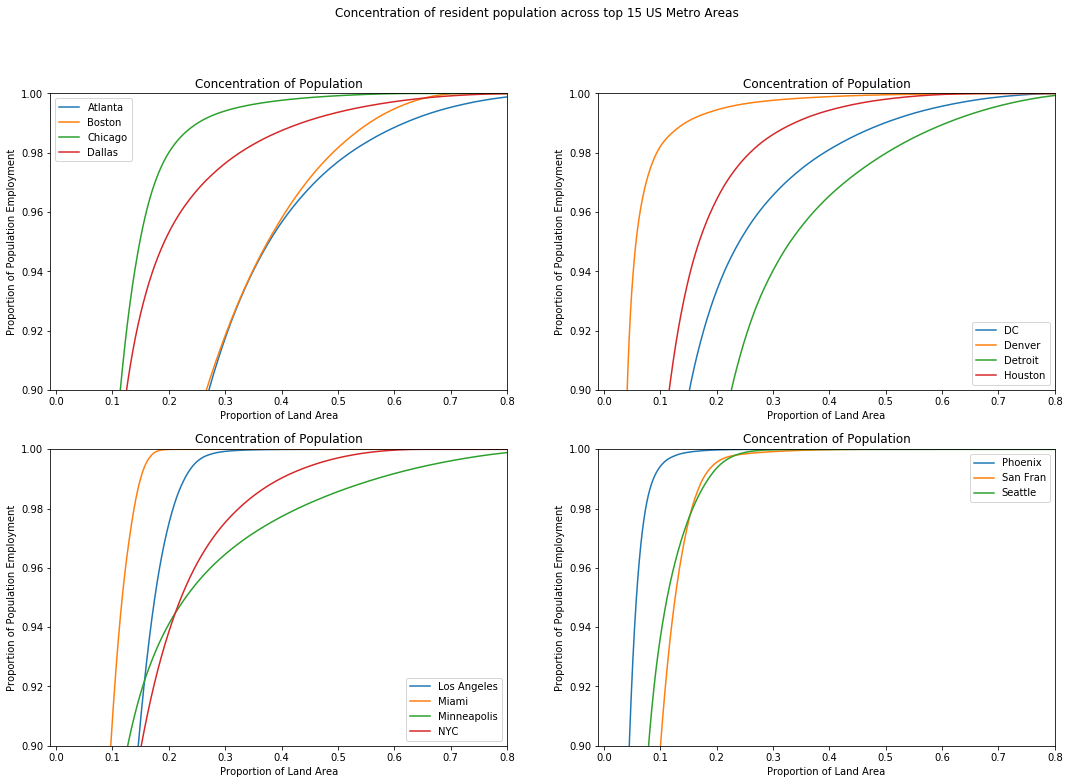

In [22]:
msa_list_1 = ['Atlanta','Boston','Chicago','Dallas']
msa_list_2 = ['DC','Denver','Detroit','Houston']
msa_list_3 = ['Los Angeles','Miami','Minneapolis','NYC']
msa_list_4 = ['Phoenix','San Fran','Seattle']

msa_lists = [msa_list_1,msa_list_2,msa_list_3,msa_list_4]

fig,ax = plt.subplots(2,2,figsize=(18,12))

a = 0
for i in range(2):
    for j in range(2):
        msa_list = msa_lists[a]
        
        a = a + 1

        for msa in msa_list:
            msa_df = blocks_dict[msa]
            area_props = msa_df['Cumulative Land - Pop']
            pop_props = msa_df['Cumulative Residents']

            ax[i,j].plot(area_props,pop_props,label=msa)

            ax[i,j].set_xlabel('Proportion of Land Area')
            ax[i,j].set_ylabel('Proportion of Population Employment')
            ax[i,j].set_title('Concentration of Population')
            ax[i,j].set_xlim([-0.01,0.8])
            ax[i,j].set_ylim([0.9,1.0])
            ax[i,j].legend()
        
fig.suptitle('Concentration of resident population across top 15 US Metro Areas')
plt.show()

As we can see, population is still highly concentrated, though considerably less so than employment.

Let's see population and employment concentration side-by-side, for each metro area. 

In [23]:
def plot_two_concentrations(msa):
    
    msa_df = blocks_dict[msa]
    msa_df = msa_df.sort_values(by='Work Density',ascending=False)
    
    work_area_props = msa_df['Cumulative Land - Work']
    work_props = msa_df['Cumulative Workers']
    
    fig, ax = plt.subplots(1, 1, figsize=(12, 8))
    ax.plot(work_area_props,work_props,label='Employment')
        
    msa_df = msa_df.sort_values(by='Pop Density',ascending=False)
    
    pop_area_props = msa_df['Cumulative Land - Pop']
    pop_props = msa_df['Cumulative Residents']
    
    ax.plot(pop_area_props,pop_props,label='Population')
    
    ax.set_xlabel('Proportion of Land Area')
    ax.set_ylabel('Proportion of Employment and Residential Population')
    
    ax.set_title('Geographic Concentration of Economic Life in Metropolitan ' + str(msa) +  '\n Employment and Population')
    ax.set_xlim([-0.01,0.8])
    ax.set_ylim([0.9,1.0])
    ax.legend()
    

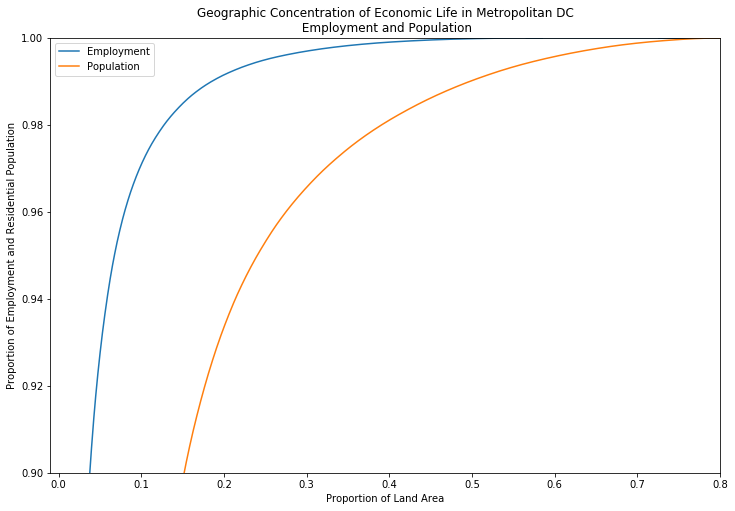

In [24]:
plot_two_concentrations('DC')

/opt/anaconda3/lib/python3.7/site-packages/IPython/core/pylabtools.py:128: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


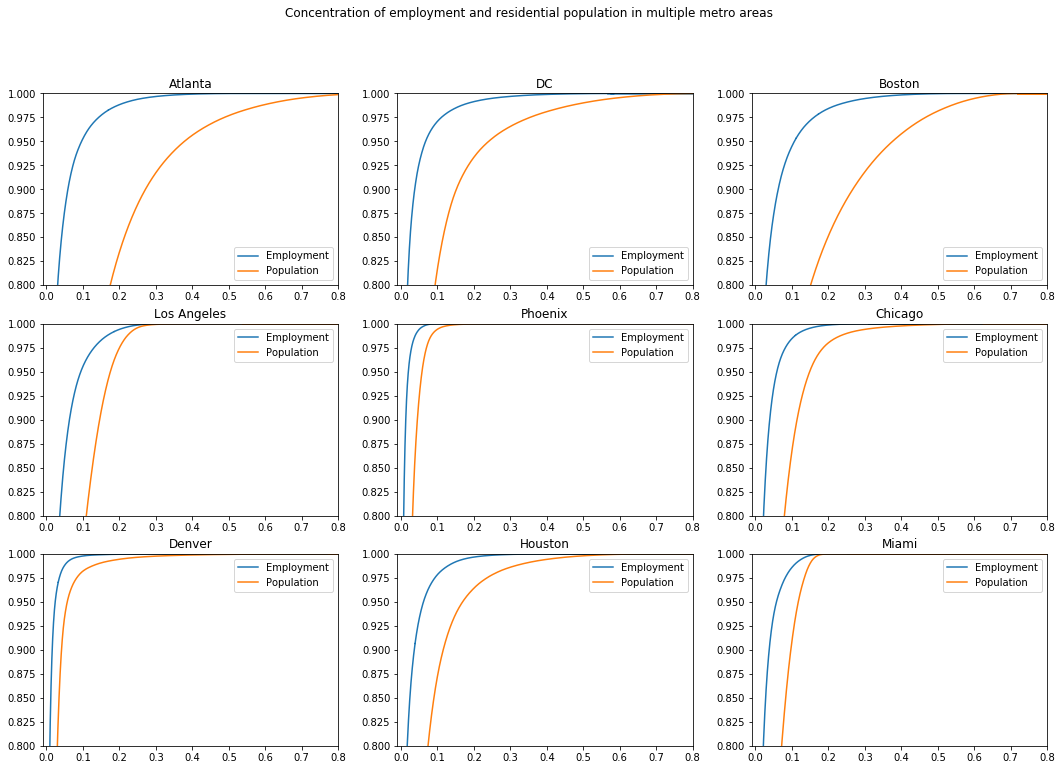

In [25]:
#msa_list = ['Atlanta','DC','Boston','Los Angeles']

msa_list = ['Atlanta','DC','Boston','Los Angeles','Phoenix','Chicago','Denver','Houston','Miami']

fig,ax = plt.subplots(3,3,figsize=(18,12))

a = 0
for i in range(3):
    for j in range(3):
        msa = msa_list[a]
        
        a = a + 1

        msa_df = blocks_dict[msa]
        msa_df = msa_df.sort_values(by='Work Density',ascending=False)

        work_area_props = msa_df['Cumulative Land - Work']
        work_props = msa_df['Cumulative Workers']

        #fig, ax = plt.subplots(1, 1, figsize=(12, 8))
        ax[i,j].plot(work_area_props,work_props,label='Employment')

        msa_df = msa_df.sort_values(by='Pop Density',ascending=False)
    
        pop_area_props = msa_df['Cumulative Land - Pop']
        pop_props = msa_df['Cumulative Residents']

        ax[i,j].plot(pop_area_props,pop_props,label='Population')

        #ax[i,j].set_xlabel('Proportion of Land Area')
        #ax[i,j].set_ylabel('Proportion of Employment and Residential Population')

        ax[i,j].set_title(str(msa))
        ax[i,j].set_xlim([-0.01,0.8])
        ax[i,j].set_ylim([0.8,1.0])
        ax[i,j].legend()
        
fig.suptitle('Concentration of employment and residential population in multiple metro areas')
#fig.subtitle('Land area')
plt.show()

Still....this doesn't show us that much. It just shows us that the degree of concentration of employment and population is fairly aligned within a given metro area.

Let's see another metric of concentration here: this time, ratio of employment to population per block in a given metro area.

In [26]:
msa_blocks = []

for msa in MSAs:
    df_blocks = blocks_dict[msa]
    df_blocks['Work-Life Total'] = df_blocks['Population'] + df_blocks['Commuters']
    df_blocks['Work Ratio'] = df_blocks['Commuters']/df_blocks['Work-Life Total']
    df_blocks['Work Ratio'] = df_blocks['Work Ratio'].fillna(0)
    
    df_blocks = df_blocks.sort_values(by='Work Ratio',ascending=False)
    
    msa_blocks.append(df_blocks)
    
blocks_dict = dict(zip(MSAs,msa_blocks))

In [27]:
msa_list = ['Atlanta','Boston','Chicago','Dallas']

msa_list = ['Phoenix']

In [28]:
def plot_work_ratio(msa_list):
    
    fig, ax = plt.subplots(1, 1, figsize=(12, 8))
    
    for msa in msa_list:
        
        df = blocks_dict[msa]
        
        ax.plot(range(len(df)),df['Work Ratio'],label=msa)
    
    ax.set_ylabel('Employment proportion')
    ax.set_xlabel('Rank')
    ax.legend()

    ax.set_title('Block Rank and Employment Ratio')

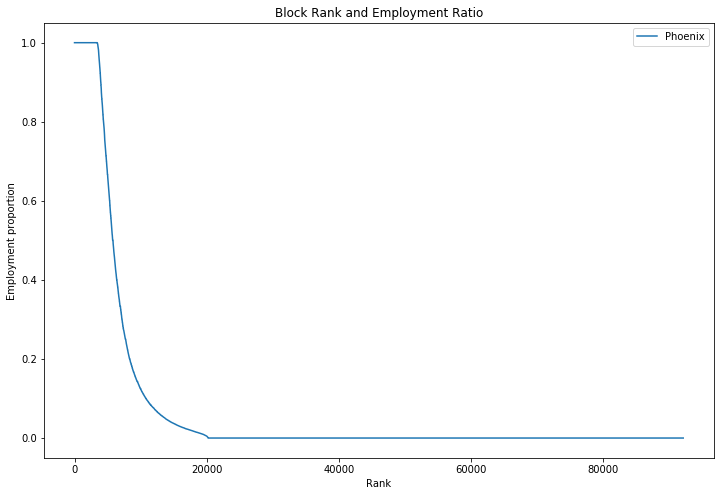

In [29]:
plot_work_ratio(msa_list)

In most metro areas, the great majority of blocks have no commercial/employment activity.

### Geographic Analysis

The above gives an indication of the degree to which employment and population are concentrated in any given metropolitan area. But these say nothing of the clustering of these two into discrete-ish units, which in fact they are (especially employment). This is what we need to focus on next. 

Next: Getting clusters for various cutoffs, and then syncing them with shapefiles.

Let's subset just those blocks that represent 75% of employment in the metro area for all of these MSAs (and also 50, 90, etc.). 

In [30]:
blocks_50 = []
blocks_75 = []
blocks_90 = []

for msa in MSAs:
    df = blocks_dict[msa]
    
    df = df.sort_values(by='Work Density',ascending=False)
    df = df.reset_index()
    df = df.drop(['index'],axis=1)
    
    df_50 = df.loc[df['Cumulative Workers'] < 0.50]
    df_75 = df.loc[df['Cumulative Workers'] < 0.75]
    df_90 = df.loc[df['Cumulative Workers'] < 0.90]
    
    blocks_50.append(df_50)
    blocks_75.append(df_75)
    blocks_90.append(df_90)
    
blocks_50_dict = dict(zip(MSAs,blocks_50))
blocks_75_dict = dict(zip(MSAs,blocks_75))
blocks_90_dict = dict(zip(MSAs,blocks_90))

In [31]:
areas_50 = []
areas_75 = []
areas_90 = []

for msa in MSAs:
    area_50 = np.sum(blocks_50_dict[msa]['Land Area'])
    area_75 = np.sum(blocks_75_dict[msa]['Land Area'])
    area_90 = np.sum(blocks_90_dict[msa]['Land Area'])
    
    areas_50.append(area_50)
    areas_75.append(area_75)
    areas_90.append(area_90)

df_50 = pd.DataFrame({
    "MSA": MSAs,
    "Area - 50% Workforce": areas_50,
    "Area Proportion": pd.Series(areas_50)/pd.Series(msa_areas)})

df_75 = pd.DataFrame({
    "MSA": MSAs,
    "Area - 75% Workforce": areas_75,
    "Area Proportion": pd.Series(areas_75)/pd.Series(msa_areas)})

df_90 = pd.DataFrame({
    "MSA": MSAs,
    "Area - 90% Workforce": areas_90,
    "Area Proportion": pd.Series(areas_90)/pd.Series(msa_areas)})

df_50 = df_50.sort_values(by='Area Proportion',ascending=False)
df_75 = df_75.sort_values(by='Area Proportion',ascending=False)
df_90 = df_90.sort_values(by='Area Proportion',ascending=False)

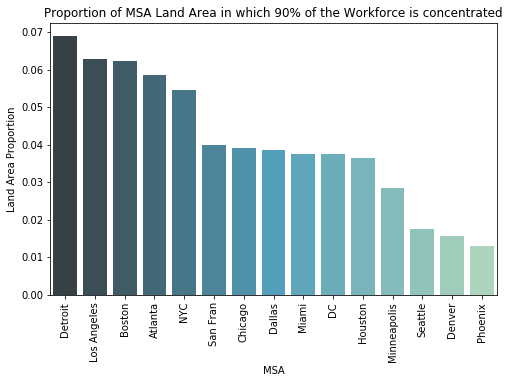

In [32]:
fig, ax = plt.subplots(1, 1, figsize=(8, 5))
ax = sns.barplot(x="MSA", y="Area Proportion", data=df_90,palette = "GnBu_d")
ax.set_ylabel('Land Area Proportion')
ax.set_xlabel('MSA')
ax.set_title('Proportion of MSA Land Area in which 90% of the Workforce is concentrated')
for tick in ax.get_xticklabels():
    tick.set_rotation(90)

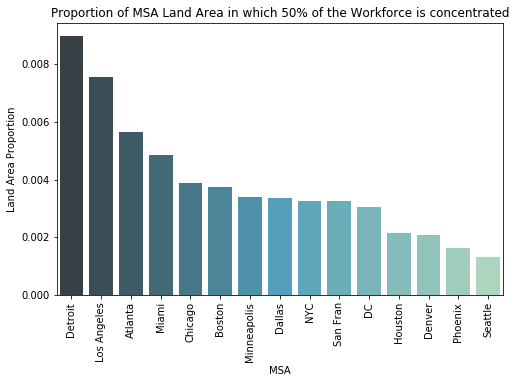

In [33]:
fig, ax = plt.subplots(1, 1, figsize=(8, 5))
ax = sns.barplot(x="MSA", y="Area Proportion", data=df_50,palette = "GnBu_d")
ax.set_ylabel('Land Area Proportion')
ax.set_xlabel('MSA')
ax.set_title('Proportion of MSA Land Area in which 50% of the Workforce is concentrated')
for tick in ax.get_xticklabels():
    tick.set_rotation(90)

Text(0.5, 1.0, 'Block Rank and Employment Ratio in densest blocks')

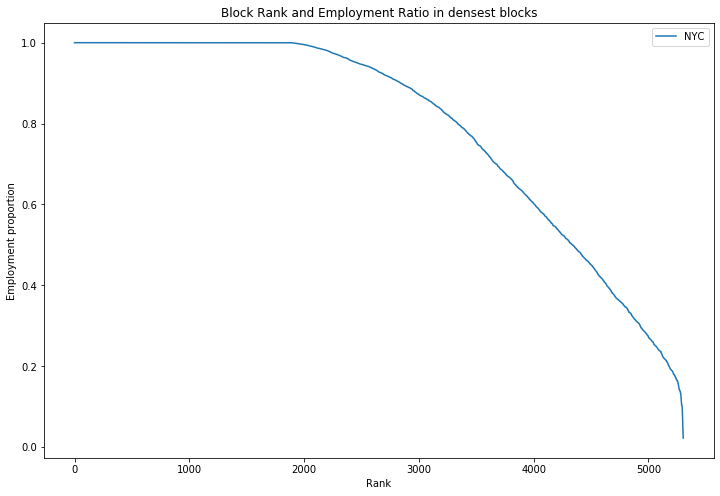

In [34]:
fig, ax = plt.subplots(1, 1, figsize=(12, 8))
    
msa = 'NYC'
df = blocks_50_dict[msa]
df = df.sort_values(by='Work Ratio',ascending=False)
        
ax.plot(range(len(df)),df['Work Ratio'],label=msa)
    
ax.set_ylabel('Employment proportion')
ax.set_xlabel('Rank')
ax.legend()

ax.set_title('Block Rank and Employment Ratio in densest blocks')

Ok, now let's save these.

In [35]:
os.chdir('/Users/thomashill/Dropbox/Academic/Dissertation/Empirics/OD_Project/New cluster blocks')

for msa in MSAs:
    b_50 = blocks_50_dict[msa]
    b_75 = blocks_75_dict[msa]
    b_90 = blocks_90_dict[msa]
    
    b_50.to_csv(str(msa)+'_blocks_50.csv')
    b_75.to_csv(str(msa)+'_blocks_75.csv')
    b_90.to_csv(str(msa)+'_blocks_90.csv')

### Cluster analysis

In [36]:
os.chdir('/Users/thomashill/Dropbox/Academic/Dissertation/Empirics/OD_Project/Clusters CSVs')

MSAs = ['Atlanta','Boston','Chicago','Dallas','DC','Denver','Detroit','Houston','LA','Miami','Minn',
        'NYC','Phoenix','SF','Seattle']



In [37]:
rel_cols = ['ID','GEOID10']

clusters_dfs = []
for msa in MSAs:
    cluster_df = pd.read_csv(str(msa)+'_Clusters.csv')
    if msa == 'NYC':
        nyc_cols = ['ID','BLOCKID10','GEOID10']
        cluster_df = cluster_df[nyc_cols]
        cluster_df['BLOCKID10'] = cluster_df['GEOID10'].fillna(cluster_df['BLOCKID10'])
        cluster_df = cluster_df[rel_cols]
        cluster_df = cluster_df.rename(columns={'BLOCKID10':'GEOID10'})
        
    else:
        cluster_df = cluster_df[rel_cols]
    
    cluster_df = cluster_df.rename(columns={'ID':"Cluster",'GEOID10':"Block"})
    cluster_df.insert(0,"MSA",msa)
    clusters_dfs.append(cluster_df)
    
clusters_dict = dict(zip(MSAs,clusters_dfs))

In [38]:
#Renaming the keys of the old dictionary
old_MSAs = ['Atlanta','Boston','Chicago','Dallas','DC','Denver','Detroit','Houston','Los Angeles','Miami','Minneapolis',
        'NYC','Phoenix','San Fran','Seattle']

od_dict['LA'] = od_dict.pop('Los Angeles')
od_dict['SF'] = od_dict.pop('San Fran')
od_dict['Minn'] = od_dict.pop('Minneapolis')

#### Assigning clusters to corresponding blocks in the OD-dataframes

In [39]:
#Note: The below is time consuming and has been done, so let's not do it again
#note also that the nyc one is messed up, most likely because one of the two is missing the 
#NJ Blocks. At some point, you will have to fix this.

#ods_clusters = []
#for msa in MSAs:
#    od_df = od_dict[msa]
#    clusters_df = clusters_dict[msa]
#    
#    rel_blocks = list(set(clusters_df['Block']))
#    
#    clusters_assigned = []
#    
#    for block in rel_blocks:
#        cluster_id = np.array(clusters_df.loc[clusters_df['Block'] == block]['Cluster'])[0]
#        block_df = od_df.loc[od_df['w_geocode'] == block]
#        block_df.insert(0,"Cluster",cluster_id)
#        clusters_assigned.append(block_df)
#    
#    clusters_assigned = pd.concat(clusters_assigned)
#    
#    ods_clusters.append(clusters_assigned)
#
#od_clusters_dict = dict(zip(MSAs,ods_clusters))

In [40]:
os.chdir('/Users/thomashill/Dropbox/Academic/Dissertation/Empirics/OD_Project')

In [41]:
ods_all = pd.read_csv('ods_all.csv')

In [42]:
MSAs = list(set(ods_all['City']))

In [43]:
#And let's make a dictionary out of the above, to make the dataframe filtering faster

msa_dfs = []
for msa in MSAs:
    msa_df = ods_all.loc[ods_all['City']==msa]
    msa_dfs.append(msa_df)
    
od_clusters_dict = dict(zip(MSAs,msa_dfs))

Ok! Using this newly created dictionary, we can easily visualize the commute distribution for each discrete cluster. Let's see what this looks like.

In [44]:
def get_top_clusters(msa,num=10):
    msa_df = od_clusters_dict[msa]
    top_clusters = list(msa_df['Cluster'].value_counts()[0:num].index)
    
    return top_clusters

In [80]:
def plot_msa_cluster_commutes(msa):
    
    msa_df = od_clusters_dict[msa]
    top_clusters = get_top_clusters(msa)
    
    
    fig,ax = plt.subplots(2,5,figsize=(16,8))

    dist_lim = 50

    for i in range(2):
        for j in range(5):
            order = i*5 + j
            cluster = top_clusters[order]
            
            cluster_df = msa_df[msa_df['Cluster']==cluster]
            
            ax[i,j].hist(cluster_df['Commute Distance'],bins=200)
            ax[i,j].set_yticklabels([])
            for spine in ["left", "right", "top"]:
                ax[i,j].spines[spine].set_visible(False)

            #Plot vertical line for median commute
            median = np.median(cluster_df['Commute Distance'])

            if i == 0:
                if j == 4:
                    ax[i,j].axvline(x=median, ymin=0, ymax=1,color='y',label="Median \ncommute (km)")
                    ax[i,j].legend()
                else:
                    ax[i,j].axvline(x=median, ymin=0, ymax=1,color='y')
            else:
                ax[i,j].axvline(x=median, ymin=0, ymax=1,color='y')

            ax[i,j].spines["bottom"].set_linewidth(2)
            ax[i,j].margins(y=0)
            ax[i,j].tick_params(bottom=False)
            ax[i,j].set_ylabel("Cluster " + str(i*5 + j + 1))

            ax[i,j].set_xlim([0,dist_lim])

    fig.suptitle('Distribution of Commute Distances (km) \n All Employees across top 10 Clusters in '+str(msa))
    plt.show()

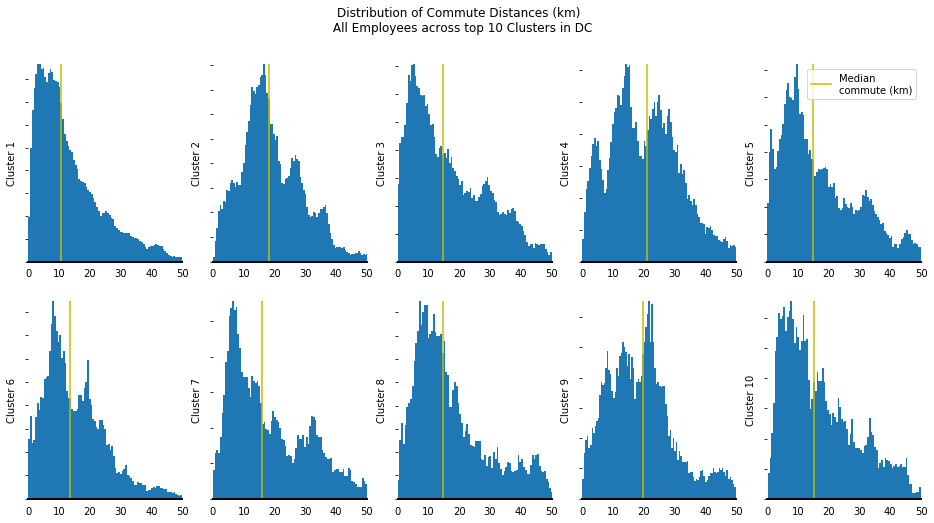

In [81]:
plot_msa_cluster_commutes('DC')

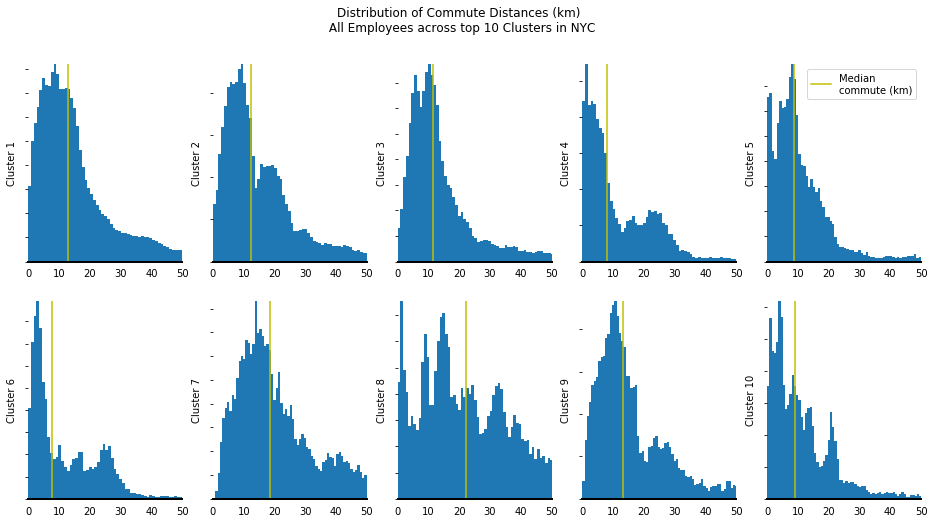

In [82]:
plot_msa_cluster_commutes('NYC')

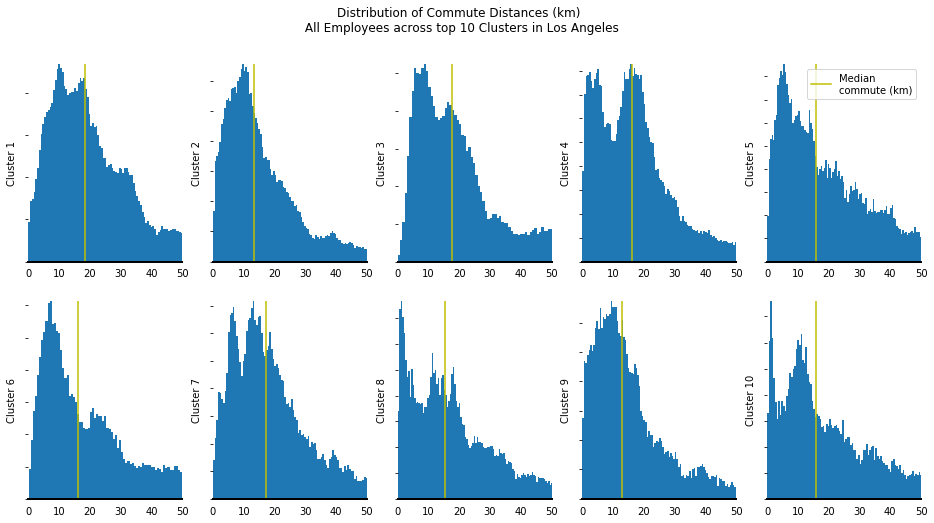

In [83]:
plot_msa_cluster_commutes('Los Angeles')

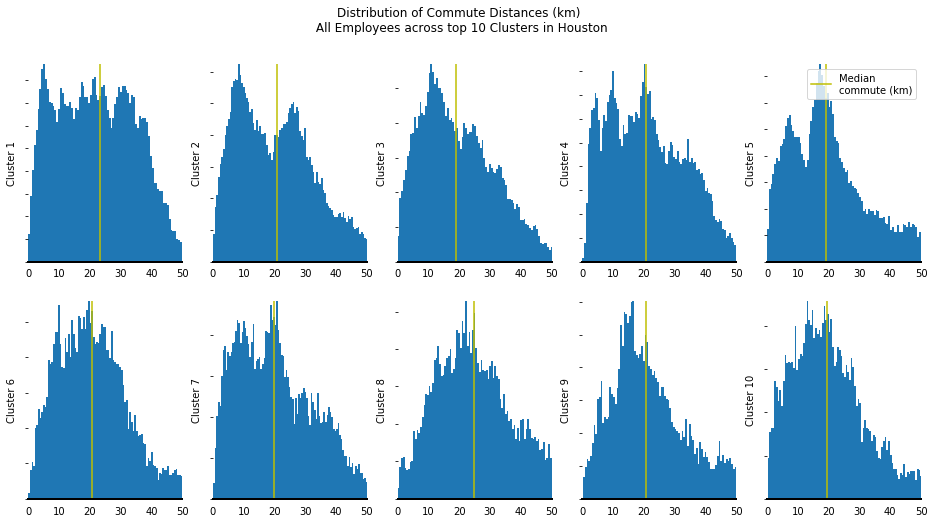

In [84]:
plot_msa_cluster_commutes('Houston')

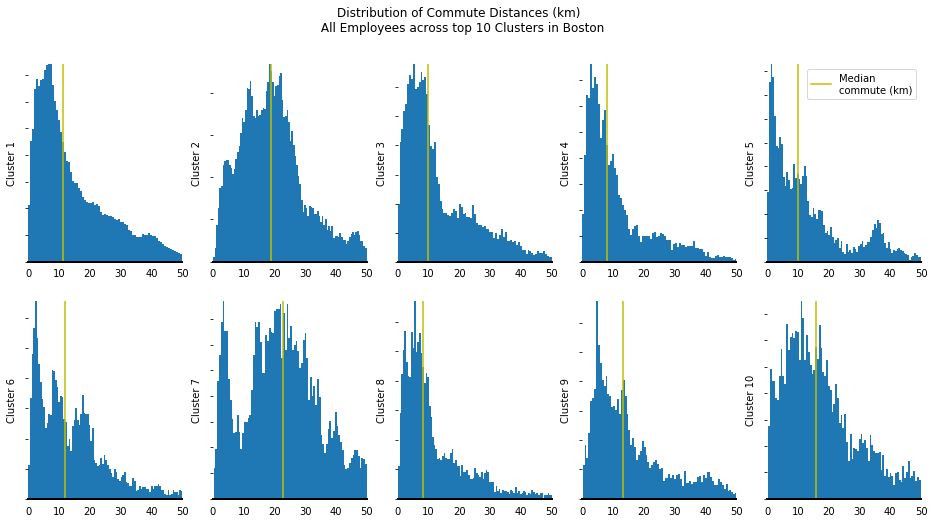

In [85]:
plot_msa_cluster_commutes('Boston')

Note: Next, make equivalent gravity and population charts.

Another hypothesis/research area: How does commute distribution relate to cluster size? That is, do large clusters necessarily have a larger portion of commuters coming for closer by? Do large clusters tend to be more left-skewed? I would guess that they are, necessarily. Although maybe not.....look at Houston.

Ok, the below takes kind of a while....probably best to do this just once and then save the new dataframe? 

In [51]:
def calculate_clusters(msa):
    msa_df = od_clusters_dict[msa]
    msa_clusters = list(set(msa_df['City-Cluster']))
    
    cluster_sizes = []
    for cluster in msa_clusters:
        cluster_df = msa_df.loc[msa_df['City-Cluster']==cluster]
        cluster_size = np.sum(cluster_df['S000'])
        cluster_sizes.append(cluster_size)

    msa_clusters_df = pd.DataFrame({
        "Cluster": msa_clusters,
        "Commuters": cluster_sizes
    })
    
    msa_clusters_df = msa_clusters_df.sort_values(by='Commuters',ascending=False)
    
    return msa_clusters_df

msa_clusters_dfs = []
for msa in MSAs:
    msa_clusters_df = calculate_clusters(msa)
    msa_clusters_dfs.append(msa_clusters_df)

msa_clusters_dict = dict(zip(MSAs,msa_clusters_dfs))    

In [52]:
#Let's save it since the above takes so long, ~30 minutes
os.chdir('/Users/thomashill/Dropbox/Academic/Courses/Inverse Problems/Final Project/Notebooks')
np.save('msa_clusters_dict.npy', msa_clusters_dict) 

In [53]:
def msa_cluster_ranksize(msa,xmax=400):
    msa_clusters_df = msa_clusters_dict[msa]
    
    fig, ax = plt.subplots(1, 1, figsize=(8, 5))
    ax.plot(np.arange(0,len(msa_clusters_df)),msa_clusters_df['Commuters'])

    ax.set_xlabel('Cluster (rank)')
    ax.set_ylabel('Cluster Size')
    ax.set_title('Rank-size plot of clusters - ' + str(msa))
    #ax.set_xlim([0,xmax])
    #ax.set_ylim([0.9,1.0])
    #ax.legend()
    #ax.set_xscale('log')
    ax.set_yscale('log')
    #ax.set_ylim([10,5000])

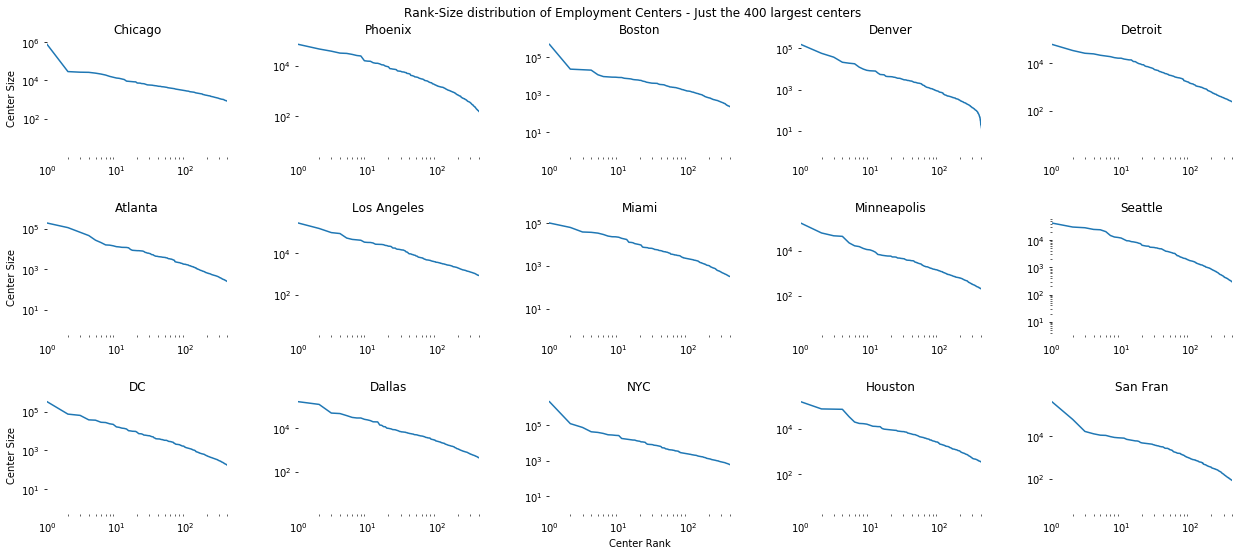

In [54]:
fig,ax = plt.subplots(3,5,figsize=(18,8))
fig.tight_layout(pad=4.0)
#ax.set_title('Rank-Size distribution of Employment Centers across 15 largest MSAs \n Just the 400 largest clusters', pad=20)

rank_max = 400

for i in range(3):
    for j in range(5):
        order = i*5 + j
        msa = MSAs[order]
        
        msa_clusters_df = msa_clusters_dict[msa]
        #msa_clusters_df = msa_clusters_df.iloc[rank_min:rank_max, :]

        #ax[i,j].plot(np.arange(0,len(msa_clusters_df)),msa_clusters_df['Commuters'])
        ax[i,j].plot(np.arange(1,len(msa_clusters_df)+1),msa_clusters_df['Commuters'])
        #ax[i,j].plot(msa_clusters_df['Commuters'],np.arange(0,len(msa_clusters_df)))
        ax[i,j].set_yticklabels([])
        for spine in ["left", "right", "top", "bottom"]:
            ax[i,j].spines[spine].set_visible(False)
        
        ax[i,j].spines["bottom"].set_linewidth(2)
        ax[i,j].tick_params(bottom=False)
        ax[i,j].set_title(msa)
        ax[i,j].set_yscale('log')
        ax[i,j].set_xscale('log')
        ax[i,j].set_xlim([1,rank_max])
        
        
        if j==0:
            ax[i,j].set_ylabel('Center Size')
            
        if j==2:
            if i==2:
                ax[i,j].set_xlabel('Center Rank')

fig.suptitle('Rank-Size distribution of Employment Centers - Just the 400 largest centers')
#fig.subtitle('Cluster Rank')
plt.show()

#### Fitting to the Pareto distribution

Because it is common practice to fit economic and social phenomena to the Pareto distribution, let's see how this works for the distribution of employment clusters. Let's do this, first, with a catch: let's look only at the top 300 employment clusters in each metropolitan region. Given the extremely "long tail" of many social and economic phenomena, which makes it impractical to conclude with confidence that one has included all cases, most applications of the Pareto distribution to economic phenomena include only the top n cases. 

Let y = the number of clusters that have at least x number of commuters (this is another way of referring to a cluster's rank). 

\\[ y = C x^{-a} \\]

Where C is a constant (proportional to the largest cluster in the list) and -a is a coefficient of interest.

In [55]:
from scipy.optimize import curve_fit
import math
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score

In [56]:
def Pareto_function(x,C,a):
    return C*x**(-a)

In [57]:
#We'll also have to read in the population of each metro area
os.chdir('/Users/thomashill/Dropbox/Academic/Dissertation/Empirics/OD_Project')
msa_pops_dict = np.load('msa_pops_dict.npy',allow_pickle='TRUE').item()

In [58]:
from scipy.stats import linregress

Ok, we'll also want to get population density for each metro area.

In [59]:
msa_pop_df = pd.read_csv("MSA_Pops.csv")

In [94]:
msa_names = ['NYC','Los Angeles','Chicago','Dallas','Houston',
             'DC','Miami','Atlanta','Phoenix','Boston','San Fran',
            'Detroit','Seattle','Minneapolis','Denver']

msa_pop_df['MSA'] = msa_names
msa_density_dict = dict(zip(msa_pop_df['MSA'],msa_pop_df[' Population Density (Per Sq. Mile) ']))

msa_pop_dict = dict(zip(msa_pop_df['MSA'],msa_pop_df[' Total Population ']))

In [121]:
densities = []
pops = []

for MSA in list(commutes_df['MSA']):
    pop = msa_pop_dict[MSA]
    density = msa_density_dict[MSA]
    
    pops.append(pop)
    densities.append(density)
    
commutes_df['Population'] = [float(i.replace(',','')) for i in pops]
commutes_df['Density'] = [float(i.replace(',','')) for i in densities]

In [111]:
#commutes_df = commutes_df.drop(["level_0"],axis=1)
#commutes_df = commutes_df.drop(["index"],axis=1)


In [129]:
commutes_df['MSA']

0         Atlanta
1          Dallas
2         Houston
3         Phoenix
4         Detroit
5         Chicago
6     Minneapolis
7              DC
8         Seattle
9           Miami
10    Los Angeles
11         Denver
12       San Fran
13         Boston
14            NYC
Name: MSA, dtype: object

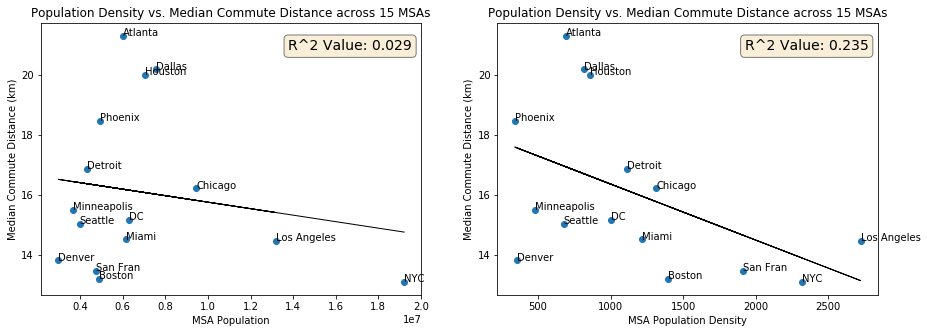

In [149]:
fig, ax = plt.subplots(1, 2, figsize=(15,5))

x = commutes_df['Population']
y = commutes_df['Median Commute']
n = commutes_df["MSA"]

ax[0].scatter(x, y)
ax[0].set_ylabel('Median Commute Distance (km)')
ax[0].set_xlabel('MSA Population')
ax[0].set_title('Population Density vs. Median Commute Distance across 15 MSAs')

#And then let's add the regression line to the plot
slope, intercept, r_value, p_value, std_err = linregress(x, y)  
ax[0].plot(x,slope*x+intercept,c= "k",linewidth=1)
disp_r_value = round(r_value**2,3)
display_text = "R^2 Value: "+ str(disp_r_value)

props = dict(boxstyle='round', facecolor='wheat', alpha=0.5)
# place a text box in upper left in axes coords
ax[0].text(0.65, 0.9, display_text, transform=ax[0].transAxes, fontsize=14,bbox=props)

for i, txt in enumerate(n):
    ax[0].annotate(txt, (x[i], y[i]))
    
x = commutes_df['Density']
y = commutes_df['Median Commute']
n = commutes_df["MSA"]

ax[1].scatter(x, y)
ax[1].set_ylabel('Median Commute Distance (km)')
ax[1].set_xlabel('MSA Population Density')
ax[1].set_title('Population Density vs. Median Commute Distance across 15 MSAs')

#And then let's add the regression line to the plot
slope, intercept, r_value, p_value, std_err = linregress(x, y)  
ax[1].plot(x,slope*x+intercept,c= "k",linewidth=1)
disp_r_value = round(r_value**2,3)
display_text = "R^2 Value: "+ str(disp_r_value)

props = dict(boxstyle='round', facecolor='wheat', alpha=0.5)
# place a text box in upper left in axes coords
ax[1].text(0.65, 0.9, display_text, transform=ax[1].transAxes, fontsize=14, bbox=props)

for i, txt in enumerate(n):
    ax[1].annotate(txt, (x[i], y[i]))

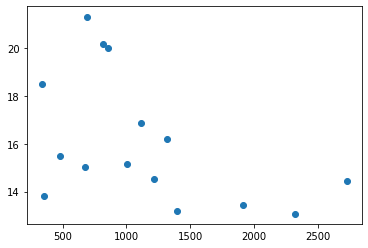

In [123]:
plt.scatter(commutes_df['Density'],commutes_df['Median Commute'])

In [62]:
#Let's first fit to the Pareto distribution
rsqs = []
params = []
a_vals = []
msa_pops= []

rank_cutoff = 400

for msa in MSAs:
    msa_df = msa_clusters_dict[msa]
    msa_df = msa_df.iloc[0:rank_cutoff]
    #msa_df = msa_df[msa_df['Commuters']>500] #Let's try this - taking just the larger clusters, above 1000
    
    #msa_x = np.log(np.array(msa_df['Commuters']))
    msa_x = np.array(msa_df['Commuters'])
    msa_y = np.arange(0,len(msa_df))
    
    popt,pcov = curve_fit(Pareto_function,msa_x,msa_y)
    est_result = Pareto_function(msa_x,popt[0],popt[1])
    r_sq = r2_score(est_result,msa_y)
    
    params.append(popt)
    rsqs.append(r_sq)
    
    a_vals.append(popt[1])
    msa_pops.append(msa_pops_dict[msa])

    
ranksize_df = pd.DataFrame({
    "MSA": MSAs,
    "MSA Population": msa_pops,
    "Pareto coefficient": a_vals,
    "R Square": rsqs
})

ranksize_df = ranksize_df.sort_values(by='Pareto coefficient',ascending=False)
ranksize_df = ranksize_df.reset_index()

pareto_ranksize_dict = dict(zip(MSAs,params))

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: RuntimeWarning: overflow encountered in power
  
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: RuntimeWarning: overflow encountered in multiply
  
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: RuntimeWarning: overflow encountered in power
  
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: RuntimeWarning: overflow encountered in power
  
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: RuntimeWarning: overflow encountered in multiply
  
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: RuntimeWarning: overflow encountered in power
  
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: RuntimeWarning: overflow encountered in power
  
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: RuntimeWarning: overflow encountered in multiply
  
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_la

In [63]:
ranksize_df = ranksize_df.sort_values(by="R Square",ascending=False)

In [64]:
MSA_density_mi = []
for msa in ranksize_df['MSA']:
    density = msa_density_dict[msa]
    MSA_density_mi.append(density)
    
ranksize_df['Density'] = MSA_density_mi


In [65]:
new_densities = [float(a.replace(',', '')) for a in list(ranksize_df['Density'])]

ranksize_df['Density'] = new_densities

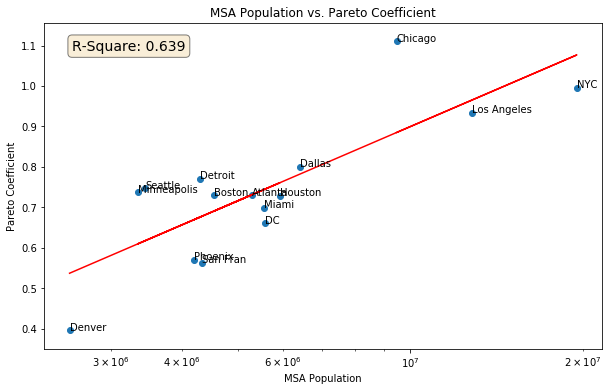

In [66]:
fig,ax = plt.subplots(1,1,figsize=(10,6))

ranksize_df = ranksize_df.sort_values(by="Pareto coefficient",ascending=False)
x = ranksize_df['MSA Population']
y = ranksize_df['Pareto coefficient']
n = ranksize_df["MSA"]

ax.scatter(x, y)
for i, txt in enumerate(n):
    ax.annotate(txt, (x[i],y[i]))

ranksize_df = ranksize_df.sort_values(by="MSA Population",ascending=True) #It's annoying I have to sort the dataframe like this.....
slope, intercept, r_value, p_value, std_err = linregress(np.log(x), y)    
ax.plot(x,slope*np.log(x)+intercept,c= "red")

disp_r2_value = round(r_value**2,3)
display_text = "R-Square: "+ str(disp_r2_value)

ax.set_title("MSA Population vs. Pareto Coefficient")
ax.set_xscale('log')
ax.set_ylabel('Pareto Coefficient')
ax.set_xlabel('MSA Population')

props = dict(boxstyle='round', facecolor='wheat', alpha=0.5)

# place a text box in upper left in axes coords
ax.text(0.05, 0.95, display_text, transform=ax.transAxes, fontsize=14,
        verticalalignment='top', bbox=props)

plt.show()

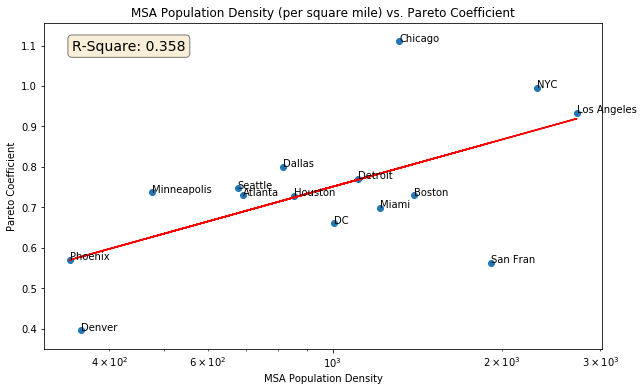

In [67]:
fig,ax = plt.subplots(1,1,figsize=(10,6))

ranksize_df = ranksize_df.sort_values(by="Pareto coefficient",ascending=False)
x = ranksize_df['Density']
y = ranksize_df['Pareto coefficient']
n = ranksize_df["MSA"]

ax.scatter(x, y)
for i, txt in enumerate(n):
    ax.annotate(txt, (x[i],y[i]))

ranksize_df = ranksize_df.sort_values(by="Density",ascending=True) #It's annoying I have to sort the dataframe like this.....
slope, intercept, r_value, p_value, std_err = linregress(np.log(x), y)    
ax.plot(x,slope*np.log(x)+intercept,c= "red")

disp_r2_value = round(r_value**2,3)
display_text = "R-Square: "+ str(disp_r2_value)

ax.set_title("MSA Population Density (per square mile) vs. Pareto Coefficient")
ax.set_xscale('log')
ax.set_ylabel('Pareto Coefficient')
ax.set_xlabel('MSA Population Density')

props = dict(boxstyle='round', facecolor='wheat', alpha=0.5)

# place a text box in upper left in axes coords
ax.text(0.05, 0.95, display_text, transform=ax.transAxes, fontsize=14,
        verticalalignment='top', bbox=props)

plt.show()

Next: Perhaps do something about the proportion of total employment represented by the largest cluster?

In [68]:
#Ok, we need to map the od_dict keys to the msa_clusters_dict keys

od_dict_keys = list(od_dict.keys())
od_dict_keys.sort()

msa_dict_keys = list(msa_clusters_dict.keys())
msa_dict_keys.sort()

msa_od_map = dict(zip(msa_dict_keys,od_dict_keys))

In [69]:
top_cluster_portions = []
for msa in msa_dict_keys:
    portion = list(msa_clusters_dict[msa]['Commuters'])[0]/np.sum(od_dict[msa_od_map[msa]]['S000'])
    top_cluster_portions.append(portion)

In [70]:
top_cluster_df = pd.DataFrame({
    'MSA': msa_dict_keys,
    'Top_Cluster_Portion': top_cluster_portions})

top_cluster_df = top_cluster_df.sort_values(by="Top_Cluster_Portion",ascending=False)

top_cluster_df

,MSA,Top_Cluster_Portion
11,NYC,0.253059
13,San Fran,0.232458
1,Boston,0.220677
2,Chicago,0.180605
3,DC,0.139701
5,Denver,0.126785
10,Minneapolis,0.098959
0,Atlanta,0.084668
7,Houston,0.059502
4,Dallas,0.054818
